# Part 4 - Saving Images to Disk

So in light of trying to train an initial classifier to benchmark it has became apparent that the MAJOR bottleneck in training time.  So due to this I will commit the disk space to storing the matrices directly and not do the computationally expensive image processing for every mini batch.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pydicom

from rnsa_funcs import *

import os
import gc
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import util
from skimage import transform

import pickle

%matplotlib inline

warnings.filterwarnings('ignore')

In [8]:
#Setup path locations
BASE_PATH = 'G:\Kaggle\RSNA_Comp'
TRAIN_PATH_RAW = 'G:\Kaggle\RSNA_Comp\stage_1_train_images'
#TEST_PATH_RAW = 'G:\Kaggle\RSNA_Comp\stage_1_test_images'
TRAIN_PATH_CLEAN = 'G:\Kaggle\RSNA_Comp\\train_image_clean'
TEST_PATH_CLEAN = 'G:\Kaggle\RSNA_Comp\\test_image_clean'

TEST_PATH_RAW = 'G:\Kaggle\RSNA_Comp\stage_2_test_images'

In [3]:
#Import dataframes from csvs
train_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'train_frame.csv'))
val_1_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_1_frame.csv'))
val_2_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_2_frame.csv'))
test_frame = pd.read_csv(os.path.join(TEST_PATH_CLEAN, 'test_frame.csv'))

#Import train labels for drawing bounding boxes
train_labels = pd.read_csv(os.path.join(BASE_PATH, 'stage_1_train_labels.csv'))

In [10]:
test_stg2_frame = pd.read_csv(os.path.join(BASE_PATH, 'stage_2_sample_submission.csv'))

So let's modify the original cleanse image function to save images to disk.  Also I will need to create a dataframe of the bounding box coordinates and save this to disk also.

In [4]:
def Save_img_batch(df, inpath, outpath, test_flg = 0, label_df = None):
    #Setup Variables
    m = df.shape[0]
    #out_img_batch = np.zeros((m, 1024, 1024))
    
    
    #Setup output dataframe for bounding boxes if needed
    if test_flg == 1 :
        transform_dict = {}
    else :
        out_label_df = label_df[0:0]
        
        #Generate One Hot array for classifier
        out_oh = pd.DataFrame()
        out_oh['tar_0'] = df['Target_adv'].map( {0: 1, 1: 0, 2:0 } ).astype(int)
        out_oh['tar_1'] = df['Target_adv'].map( {0: 0, 1: 1, 2:0 } ).astype(int)
        out_oh['tar_2'] = df['Target_adv'].map( {0: 0, 1: 0, 2:1 } ).astype(int)
        out_label_OH = out_oh.values
    
    for i in range(m) :
        #Splitting patient id out for querying the labels
        patient_id = df['patientId'][i]
        in_filename = patient_id + '.dcm'
        out_filename = patient_id + '.npy'
        
        #Import patient data
        full_dicom = pydicom.read_file(os.path.join(inpath, in_filename))
        img = full_dicom.pixel_array
        
        #cleanse image data
        new_img, img_trans_func = Cleanse_img(img)
        
        #output for debugging
        #out_img_batch[i] = new_img

        #Save to disk
        np.save(os.path.join(outpath,out_filename), new_img)  
        
        if i % 1000 == 0 & i > 0 :
            print('Created :', i)
        
        #Put transformation functions into dictionary if it is test set
        if test_flg == 1 :
            #Append personid to output transformation dictionary
            transform_dict[patient_id] = img_trans_func
            
        else :
            #Otherwise generate bounding box and save to dataframe
            
            #Get target
            has_bb = df['Target_adv'][i]
            
            #Check whether this has a bounding box
            if has_bb == 2:
                #Check that has label dataframe
                if label_df is None :
                    print('NO LABEL DATAFRAME')
                    break
                else :
                    pat_label = label_df.loc[label_df.patientId == patient_id, 
                                             ['x', 'y', 'width', 'height']].values
                    
                    #Get number of bounding boxes
                    n = pat_label.shape[0]

                    #enumerate through bounding boxes and transform all
                    for j in range(n):
                        #Was getting odd error of variable referenced before assignment so reassigning here
                        pat_label = label_df.loc[label_df.patientId == patient_id, 
                                             ['x', 'y', 'width', 'height']].values
                        #Generate new bounding box
                        b_box = pat_label[j, :]
                        new_b_box = convert_bb(b_box, img_trans_func)
                        
                        #Create dataframe and append to output dataframe
                        box_dict = {'patientId' : patient_id, 
                                   'x' : new_b_box[0],
                                   'y' : new_b_box[1],
                                   'width' :new_b_box[2],
                                   'height' : new_b_box[3],
                                   'Target' : 1}
                        append_df = pd.DataFrame(data=box_dict, index=[0])
                        out_label_df = out_label_df.append(append_df, ignore_index=True)
                        
                        
                        #Cleanup
                        del append_df, box_dict, b_box, new_b_box, pat_label
                
                del has_bb
         
        #Cleanup for next pass
        del patient_id, in_filename, out_filename, full_dicom, img, new_img, img_trans_func

    gc.collect()
    if test_flg == 1 :
        return transform_dict
    else :
        return out_label_df, out_label_OH

Create test dataframe

In [5]:
img_tst = val_2_frame.head(5)

In [6]:
img_tst

,patientId,PatientsSex,PatientsAge,ViewPosition,PixelSpacing,Age_Band,Target_adv
0,a10484ee-bd1a-4eb0-9df3-1947a31991e7,M,54,PA,0.143,"(50, 60]",0
1,ee1afccd-73db-442f-8465-f85dee2db2fe,M,19,AP,0.168,"(18, 30]",0
2,b71d89cc-dd37-4883-830e-cba59a8f8e6e,M,73,AP,0.139,"(70, 80]",1
3,c8b4cab0-ad2f-43dd-96e4-cd6b81f93a6a,F,18,PA,0.143,"(0, 18]",0
4,e2f25144-dca3-4cd6-8e3b-97c3742d2102,F,46,AP,0.168,"(40, 50]",1


In [106]:
labels_tf, oh_labels = Save_img_batch(img_tst, TRAIN_PATH_RAW, TRAIN_PATH_CLEAN, test_flg = 0, label_df = train_labels)

So this seems to work correctly.  Now to build an input step.  First a step for the classifier stage.

In [12]:
#Classifier input
def In_img_CL(df, inpath, test_flg = 0):
    #Setup Variables
    m = df.shape[0]
    out_img_batch = np.zeros((m, 1024, 1024))
    
    if test_flg != 1:         
        #Generate One Hot array for classifier
        out_oh = pd.DataFrame()
        out_oh['tar_0'] = df['Target_adv'].map( {0: 1, 1: 0, 2:0 } ).astype(int)
        out_oh['tar_1'] = df['Target_adv'].map( {0: 0, 1: 1, 2:0 } ).astype(int)
        out_oh['tar_2'] = df['Target_adv'].map( {0: 0, 1: 0, 2:1 } ).astype(int)
        out_label_OH = out_oh.values
    
    for i in range(m) :
        #Splitting patient id out for querying the labels
        patient_id = df['patientId'][i]
        in_filename = patient_id + '.npy'
        
        #Import patient data
        img = np.load(os.path.join(inpath, in_filename))
        
        #Transform image to normalize for model processing
        out_img_batch[i] = img

    gc.collect()
    
    out_img_batch = out_img_batch.reshape(m, 1024, 1024, 1)
    if test_flg == 1 :
        return out_img_batch
    else :
        return out_img_batch, out_label_OH

In [110]:
img_arr, Y_OH = In_img_CL(img_tst, TRAIN_PATH_CLEAN, test_flg=0)

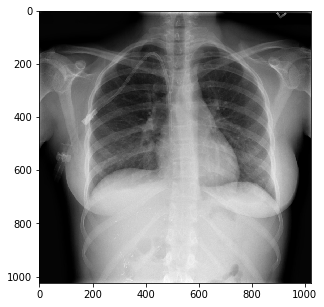

In [111]:
plt.figure(figsize=(5,5))
plt.imshow(img_arr[3, :, :, 0], cmap='gray')

Now to test for the testing outputs.

The difference is for the test/val2 sets I will be saving the image transformation dictionary and performing inverse bounding box transforms for the outputs, wheras the train/val1 sets I will be training and comparing against the pre-transformed bounding boxes so I simply need to save the bounding box dataframes instead of the transformation data. 

This should give a good compromise between computational efficiency and validation robustness.

In [120]:
transform_dict = Save_img_batch(img_tst, TRAIN_PATH_RAW, TRAIN_PATH_CLEAN, test_flg = 1, label_df = train_labels)

In [121]:
transform_dict

{'a10484ee-bd1a-4eb0-9df3-1947a31991e7': <skimage.transform._geometric.ProjectiveTransform at 0xf13eda0>,
 'ee1afccd-73db-442f-8465-f85dee2db2fe': <skimage.transform._geometric.ProjectiveTransform at 0xf13eef0>,
 'b71d89cc-dd37-4883-830e-cba59a8f8e6e': <skimage.transform._geometric.ProjectiveTransform at 0xf13ec88>,
 'c8b4cab0-ad2f-43dd-96e4-cd6b81f93a6a': <skimage.transform._geometric.ProjectiveTransform at 0xf1f9940>,
 'e2f25144-dca3-4cd6-8e3b-97c3742d2102': <skimage.transform._geometric.ProjectiveTransform at 0xf13e630>}

This seems to work nicely also.  So now let's generate all of the numpy arrays.

WARNING - this will require about 200-300Gb of disk space.

In [122]:
#val_1_lab_df, oh_labels = Save_img_batch(val_1_frame, TRAIN_PATH_RAW, TRAIN_PATH_CLEAN, test_flg = 0, label_df = train_labels)

In [124]:
#val_1_lab_df.to_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_1_labels_tf.csv'), index=True)

Save Validation 2.

In [125]:
#val_2_tfs = Save_img_batch(val_2_frame, TRAIN_PATH_RAW, TRAIN_PATH_CLEAN, test_flg = 1, label_df = train_labels)

In [127]:
#pickle.dump( val_2_tfs, open(os.path.join(TRAIN_PATH_CLEAN, 'val_2_tf.p'), "wb" ) )

Save Test.

In [129]:
test_set_tfs = Save_img_batch(test_frame, TEST_PATH_RAW, TEST_PATH_CLEAN, test_flg = 1, label_df = None)

In [130]:
pickle.dump( test_set_tfs, open(os.path.join(TEST_PATH_CLEAN, 'test_set_tfs.p'), "wb" ) )

And finally - the big one - Saving all of the training data.

In [131]:
train_lab_df, oh_labels = Save_img_batch(train_frame, TRAIN_PATH_RAW, TRAIN_PATH_CLEAN, test_flg = 0, label_df = train_labels)

In [132]:
train_lab_df.to_csv(os.path.join(TRAIN_PATH_CLEAN, 'train_lab_df.csv'), index=True)

Below is what I used for the stage 2 data.

In [13]:
test_set_tfs = Save_img_batch(test_stg2_frame, TEST_PATH_RAW, TEST_PATH_CLEAN, test_flg = 1, label_df = None)

In [ ]:
pickle.dump( test_set_tfs, open(os.path.join(TEST_PATH_CLEAN, 'test_set2_tfs.p'), "wb" ) )